In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [32]:
# Parameters
S0 = 100             # Initial stock index value
A0 = 100             # Initial wealth
mu = 0.10            # Drift of stock index
sigma = 0.20         # Volatility of stock index
r = 0.02             # Risk-free rate
T = 3                # Investment horizon in years
m_values = [1, 3, 5] # Multipliers to test
sims = 10000         # Number of simulation paths
dt = 1 / 12          # Monthly time step

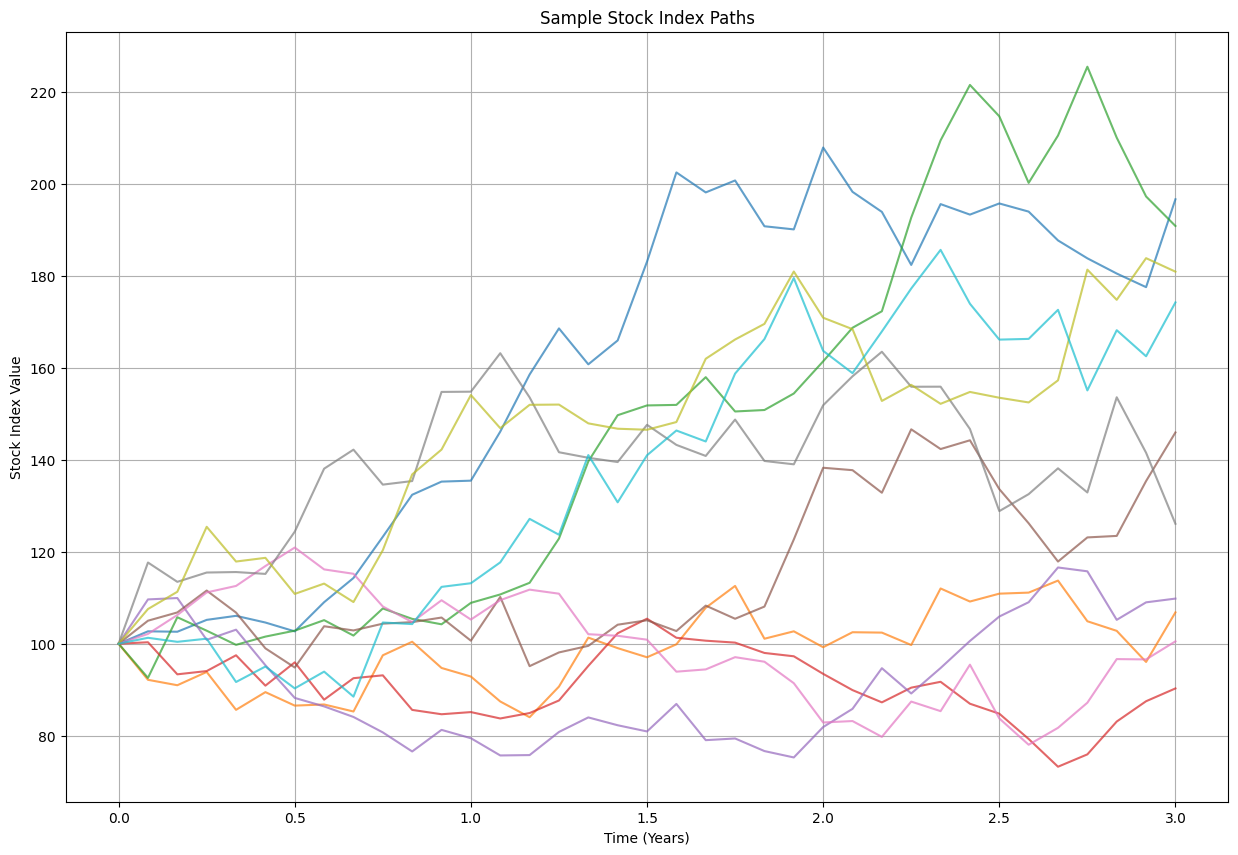

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [33]:
# Simulation of stock index paths
def gbm(S0, mu, sigma, T, dt, sims):
    steps = int(T / dt)
    S = np.zeros((sims, steps + 1))
    S[:, 0] = S0
    for t in range(1, steps + 1):
        Z = np.random.normal(0, 1, sims)
        S[:, t] = S[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

# Running simulations and plotting results
plt.figure(figsize=(15, 10))

# Plotting stock index paths
S = gbm(S0, mu, sigma, T, dt, sims)

plt.plot(np.linspace(0, T, S.shape[1]), S[:10].T, alpha=0.7)  # Plot 10 sample stock paths
plt.xlabel('Time (Years)')
plt.ylabel('Stock Index Value')
plt.title('Sample Stock Index Paths')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))


In [34]:
# CPPI strategy implementation
def cppi_strategy(S, A0, r, m, dt):
    sims, steps = S.shape
    steps -= 1
    A = np.zeros((sims, steps + 1))
    A[:, 0] = A0
    F = A0 * np.exp(-r * (T - np.arange(0, T, dt)))  # Floor level over time
    
    for t in range(steps):
        cushion = A[:, t] - F[t]
        w_t = m * (cushion / A[:, t])
        w_t = np.clip(w_t, 0, 1)  # Ensure weights are between 0 and 1
        r_A = w_t * (S[:, t + 1] - S[:, t]) / S[:, t] + (1 - w_t) * r * dt
        A[:, t + 1] = A[:, t] * (1 + r_A)
    
    return A

Multiplier m = 1:
  Minimum Return: 1.02
  Mean Return: 1.08
  25th, 50th, 75th Percentiles: [1.05833585 1.07383521 1.09303552]
Multiplier m = 3:
  Minimum Return: 1.00
  Mean Return: 1.12
  25th, 50th, 75th Percentiles: [1.03593404 1.07339008 1.14708234]
Multiplier m = 5:
  Minimum Return: 0.99
  Mean Return: 1.16
  25th, 50th, 75th Percentiles: [1.01197998 1.04418319 1.1686502 ]


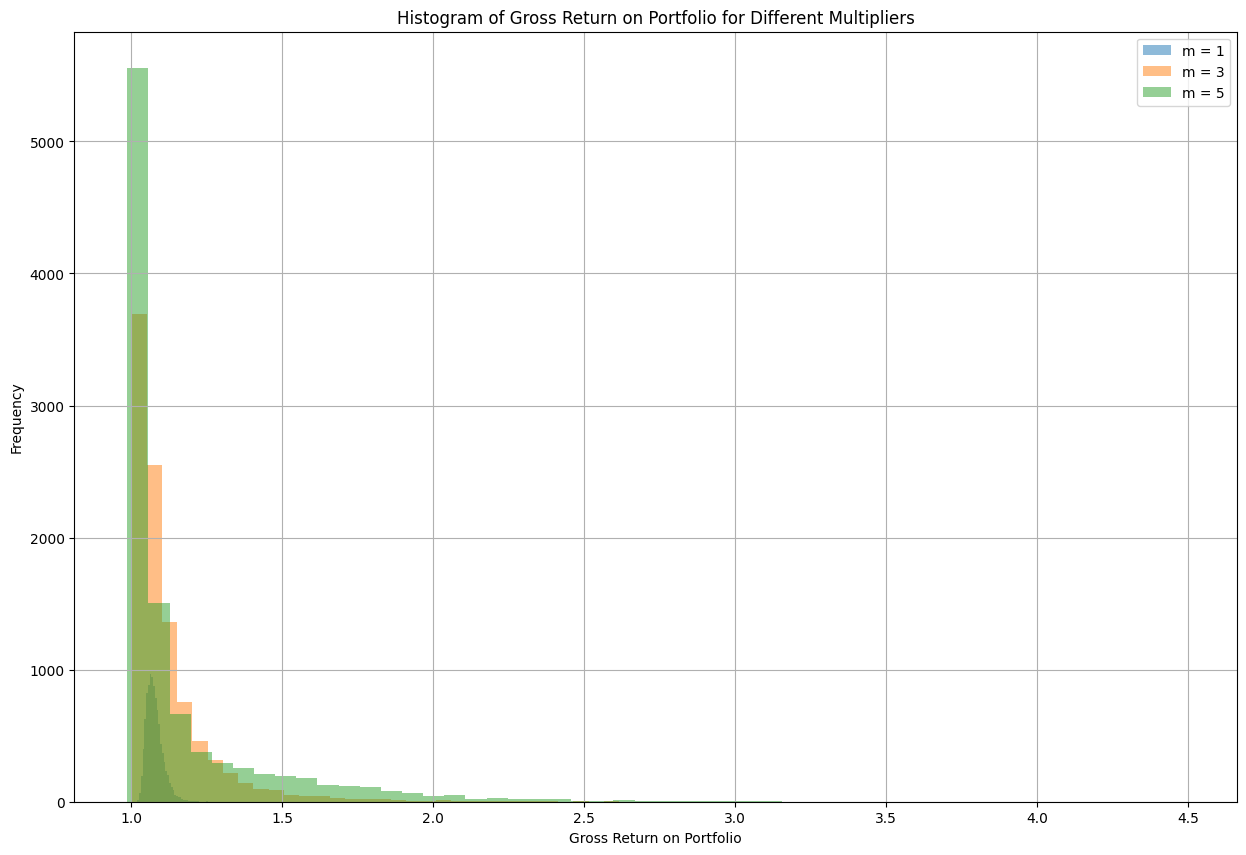

In [35]:
# Running simulations and plotting results
plt.figure(figsize=(15, 10))

for m in m_values:
    A = cppi_strategy(S, A0, r, m, dt)
    
    final_wealth = A[:, -1]
    gross_return = final_wealth / A0
    
    # Plot histogram of gross returns
    plt.hist(gross_return, bins=50, alpha=0.5, label=f'm = {m}')
    
    # Report statistics
    min_return = np.min(gross_return)
    mean_return = np.mean(gross_return)
    percentiles = np.percentile(gross_return, [25, 50, 75])
    print(f"Multiplier m = {m}:\n  Minimum Return: {min_return:.2f}\n  Mean Return: {mean_return:.2f}\n  25th, 50th, 75th Percentiles: {percentiles}")

plt.xlabel('Gross Return on Portfolio')
plt.ylabel('Frequency')
plt.title('Histogram of Gross Return on Portfolio for Different Multipliers')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
data = pd.read_csv(
    'sorted_portfolios.csv',
    index_col=0,
    sep=';',
    skiprows=15,  # Skip the metadata lines at the top of the file
    parse_dates=True,
    dayfirst=True,
    date_format=lambda x: pd.to_datetime(x, format='%d/%m/%Y'),
)

# Ensure date format is correctly parsed
data.index = pd.to_datetime(data.index, format='%d/%m/%Y', errors='coerce').dropna()

# Restrict data to the required timeframe
data = data.loc['1970-01':'2024-09']

# Eliminate portfolios with missing returns between Jan 1970 and Sep 2024
data = data.replace(-99.99, np.nan)
data = data.dropna(axis=1)

display(data.head())

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM7,ME9 BM8,ME9 BM9,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
1970-01-31,0.7340,-3.8296,-2.1362,-1.8094,-2.9966,-1.7053,-1.8570,-1.7662,-1.1123,2.3490,...,-5.0058,-5.5562,-6.5729,-9.0058,-7.1519,-6.8890,-10.3183,-7.0070,-12.9177,-9.6202
1970-02-28,0.5683,2.1634,5.0308,3.4020,3.6364,1.3910,3.3443,3.5097,5.5747,2.2305,...,9.8534,7.8106,9.4611,2.7675,5.3092,5.2111,8.1776,10.3569,7.0628,4.7917
1970-03-31,-5.1963,-7.8342,-5.4595,-5.3715,-1.6005,-2.7717,0.1079,-0.0384,-0.7886,-1.9113,...,-0.6694,2.0547,-1.1479,-2.6094,-2.3562,1.4160,-1.7056,4.4058,-0.4492,2.2456
1970-04-30,-26.0499,-22.5544,-19.4187,-20.7408,-16.6595,-16.1903,-14.6842,-12.0693,-12.7800,-12.0397,...,-8.1520,-8.6756,-8.0336,-9.7725,-10.2815,-6.0719,-12.4564,-9.2997,-7.2161,-8.5114
1970-05-31,-10.7713,-10.2212,-8.0355,-12.1791,-7.4980,-10.8278,-7.7205,-8.2600,-11.0103,-10.3062,...,-2.0031,-6.8315,-4.8904,-7.6643,-8.6930,-5.4471,-4.7861,-5.8922,0.3834,1.9215


In [37]:
def calc_struct_cov_matrix(data):
    
    # Calculate average correlation
    corr_matrix = data.corr()
    avg_corr = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)].mean()
    N = data.shape[1]
    
    # Construct constant correlation matrix
    R = np.full((N, N), avg_corr)
    np.fill_diagonal(R, 1)
    
    # Calculate the diagonal volatility matrix
    vols = data.std()
    V = np.diag(vols)
    
    # Calculate the structured covariance matrix
    struct_cov = V @ R @ V
    
    return struct_cov

In [38]:
def gmv(cov_matrix):
    
    N = cov_matrix.shape[0]
    ones = np.ones(N)
    inv_cov = np.linalg.inv(cov_matrix)
    x = ones.T @ inv_cov @ ones
    weights = (inv_cov @ ones) / x
    return weights

In [39]:
# Count the number of portfolios in the universe after eliminating missing returns
num_portfolios = data.shape[1]
print(f'Number of portfolios in the universe: {num_portfolios}')

# Calculate the structured covariance matrix for the entire sample
struct_cov_matrix = calc_struct_cov_matrix(data)

Number of portfolios in the universe: 95


In [43]:
window_size = 120  # 120 months rolling window
step = 1  # 1 month step
rolling_results = []

for start in range(0, len(data) - window_size + 1, step):
    # Extract rolling window data
    roll_data = data.iloc[start:start + window_size]
    
    # Sample covariance matrix
    sample_cov = roll_data.cov().values
    
    # Calculate the structured covariance matrix for the rolling window
    struct_cov_roll = calc_struct_cov_matrix(roll_data)
    
    # Calculate GMV portfolio weights for both covariance matrices
    gmv_weights_sample = gmv(sample_cov)
    gmv_weights_struct = gmv(struct_cov_roll)
    
    # Calculate leverage and effective number of constituents
    leverage_sample = np.sum(np.abs(gmv_weights_sample[gmv_weights_sample < 0]))
    leverage_struct = np.sum(np.abs(gmv_weights_struct[gmv_weights_struct < 0]))
    
    ENC_sample = 1 / np.sum(gmv_weights_sample ** 2)
    ENC_struct = 1 / np.sum(gmv_weights_struct ** 2)
    
    # Store results
    rolling_results.append({
        'sample_cov': sample_cov,
        'struct_cov': struct_cov_roll,
        'gmv_weights_sample': gmv_weights_sample,
        'gmv_weights_struct': gmv_weights_struct,
        'leverage_sample': leverage_sample,
        'leverage_struct': leverage_struct,
        'ENC_sample': ENC_sample,
        'ENC_struct': ENC_struct
    })

print(f'Rolling window analysis completed with {len(rolling_results)} windows.')



Rolling window analysis completed with 538 windows.


In [45]:
# Analyze the effect of using a structured covariance matrix on portfolio diversification
effect_on_diversification = []
leverage_diffs = []
ENC_diffs = []
leverage_sample_vals = []
ENC_sample_vals = []
for result in rolling_results:
    diversification_effect = {
        'leverage_diff': result['leverage_struct'] - result['leverage_sample'],
        'ENC_diff': result['ENC_struct'] - result['ENC_sample']
    }
    effect_on_diversification.append(diversification_effect)
    leverage_diffs.append(diversification_effect['leverage_diff'])
    ENC_diffs.append(diversification_effect['ENC_diff'])
    leverage_sample_vals.append(result['leverage_sample'])
    ENC_sample_vals.append(result['ENC_sample'])

print('Effect of using a structured covariance matrix on portfolio diversification calculated.')


Effect of using a structured covariance matrix on portfolio diversification calculated.


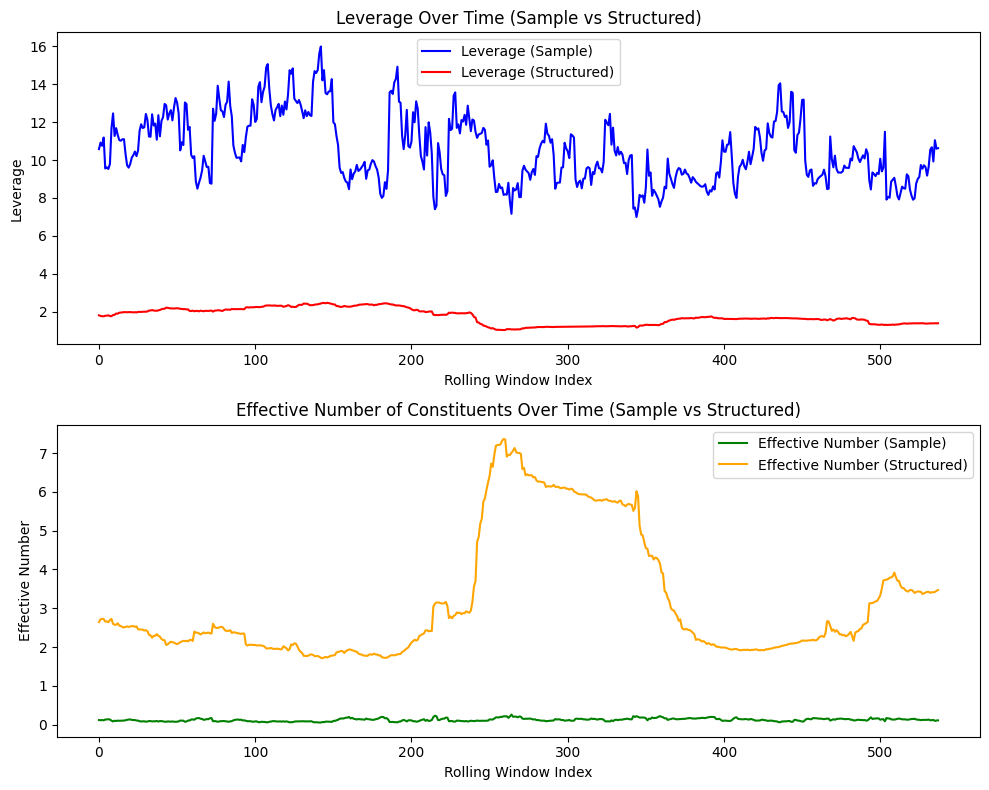

In [47]:
# Plot the effect on leverage and effective number of constituents
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot leverage differences against sample values
ax[0].plot(leverage_sample_vals, label='Leverage (Sample)', color='b')
ax[0].plot(np.array(leverage_sample_vals) + np.array(leverage_diffs), label='Leverage (Structured)', color='r')
ax[0].set_title('Leverage Over Time (Sample vs Structured)')
ax[0].set_xlabel('Rolling Window Index')
ax[0].set_ylabel('Leverage')
ax[0].legend()

# Plot effective number of constituents differences against sample values
ax[1].plot(ENC_sample_vals, label='Effective Number (Sample)', color='g')
ax[1].plot(np.array(ENC_sample_vals) + np.array(ENC_diffs), label='Effective Number (Structured)', color='orange')
ax[1].set_title('Effective Number of Constituents Over Time (Sample vs Structured)')
ax[1].set_xlabel('Rolling Window Index')
ax[1].set_ylabel('Effective Number')
ax[1].legend()

plt.tight_layout()
plt.show()